# Delahaye Enrichment Analyses

In [1]:
library(tidyverse)
library(data.table)
library(qqman)
setwd("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/")
knitr::opts_knit$set(root.dir = "/scratch/st-dennisjk-1/wcasazza/delahaye_QC/")
knitr::opts_chunk$set(echo = TRUE)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose


For example usage please run: vignette('qqman')

Citation appreciated but not required:
Turner, S.D. qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots.

## Delahaye hits

In [5]:
stage1_threshold <- 4.735834e-05

In [6]:
sex_spec <- fread("matrix_eqtl_data/cis_mQTL_9_methy_PC_all_sex_interaction.txt")
sig_sex <- sex_spec[FDR < 0.05]
stage1_threshold <- max(sig_sex$`p-value`)

In [ ]:
snps <- fread("matrix_eqtl_data/snp_pos.txt")
robust_results <- fread("delahaye_robust_regression_fdr_hits.txt")
stratified_results <- fread("delahaye_stratified_regression_fdr_hits.txt")
robust_merged_w_pos <- merge(na.omit(robust_results), snps, by = "SNP")
stratified_merged_w_pos <- merge(na.omit(stratified_results), snps, by = "SNP")

In [ ]:
hits_robust_merged <- robust_merged_w_pos[, .(gene, CHR, Male = res_m < stage1_threshold, Female = res_f < stage1_threshold)]
hits_robust_merged <- melt(hits_robust_merged[, .(Male = uniqueN(gene[Male]), Female = uniqueN(gene[Female])), by = CHR], value.vars = c("Male", "Female"), variable.name = "Sex", value.name = "Hits")
hits_robust_merged$CHR <- factor(hits_robust_merged$CHR, levels = paste0("chr", c("X", 22:1)))
hits_robust_merged$Hits[hits_robust_merged$Sex == "Male"] <- -1 * hits_robust_merged$Hits[hits_robust_merged$Sex == "Male"]
hits_robust_merged$Sex <- factor(hits_robust_merged$Sex, levels = c("Female", "Male"))
ggplot(hits_robust_merged, aes(CHR, Hits, fill = Sex)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) +
  coord_cartesian(ylim = c(-500, 500)) +
  scale_y_continuous(breaks = seq(-500, 500, 50), labels = c(seq(500, 0, -50), seq(50, 500, 50))) +
  coord_flip()


hits_stratified_merged <- stratified_merged_w_pos[, .(gene, CHR, Male = res_m < stage1_threshold, Female = res_f < stage1_threshold)]
hits_stratified_merged <- melt(hits_stratified_merged[, .(Male = uniqueN(gene[Male]), Female = uniqueN(gene[Female])), by = CHR], value.vars = c("Male", "Female"), variable.name = "Sex", value.name = "Hits")
hits_stratified_merged$CHR <- factor(hits_stratified_merged$CHR, levels = paste0("chr", c("X", 22:1)))
hits_stratified_merged$Hits[hits_stratified_merged$Sex == "Male"] <- -1 * hits_stratified_merged$Hits[hits_stratified_merged$Sex == "Male"]
hits_stratified_merged$Sex <- factor(hits_stratified_merged$Sex, levels = c("Female", "Male"))
ggplot(hits_stratified_merged, aes(CHR, Hits, fill = Sex)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) +
  coord_flip()

In [ ]:
manhattan(robust_merged_w_pos[, .(CHR = as.numeric(gsub("chr", "", gsub("X", "23", CHR))), BP = POS, P = res_f)])
manhattan(robust_merged_w_pos[, .(CHR = as.numeric(gsub("chr", "", gsub("X", "23", CHR))), BP = POS, P = res_m)])
manhattan(stratified_merged_w_pos[, .(CHR = as.numeric(gsub("chr", "", gsub("X", "23", CHR))), BP = POS, P = res_f)])
manhattan(stratified_merged_w_pos[, .(CHR = as.numeric(gsub("chr", "", gsub("X", "23", CHR))), BP = POS, P = res_m)])

In [ ]:
ggplot(robust_results, aes(-log10(res_m), -log10(res_f))) +
  geom_point()
ggplot(stratified_results, aes(-log10(res_m), -log10(res_f))) +
  geom_point()

In [ ]:
library(IlluminaHumanMethylation450kanno.ilmn12.hg19)
library(minfi)
data(IlluminaHumanMethylation450kanno.ilmn12.hg19)
annot <- getAnnotation(IlluminaHumanMethylation450kanno.ilmn12.hg19)

In [ ]:
library(GGally)
cpgs_robust_m <- unique(robust_results[robust_results$res_m < stage1_threshold, ]$gene)
cpgs_robust_m_annotations <- annot[cpgs_robust_m, ]

cpgs_robust_f <- unique(robust_results[robust_results$res_f < stage1_threshold, ]$gene)
cpgs_robust_f_annotations <- annot[cpgs_robust_f, ]

cpgs_stratified_m <- unique(stratified_results[stratified_results$res_m < stage1_threshold, ]$gene)
cpgs_stratified_m_annotations <- annot[cpgs_stratified_m, ]

cpgs_stratified_f <- unique(stratified_results[stratified_results$res_f < stage1_threshold, ]$gene)
cpgs_stratified_f_annotations <- annot[cpgs_stratified_f, ]
methy_feature_plots <- function(annotations_m, annotations_f, name = "plot") {
  annotations_m$Sex <- "Male"
  annotations_f$Sex <- "Female"
  annotations <- rbind(as.data.frame(annotations_m), as.data.frame(annotations_f))
  annotations$Relation_to_Island <- gsub(".*_", "", annotations$Relation_to_Island)
  # INSERT SHARED BAR PLOT A LA G E GXE G+E PAPER
  p1 <- ggplot(as.data.frame(annotations) %>% filter(Regulatory_Feature_Group != ""), aes(Sex, fill = Regulatory_Feature_Group, by = factor(Sex))) +
    geom_bar(position = "fill") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) +
    ggtitle(name) +
    geom_text(stat = "prop", position = position_fill(0.5))
  p2 <- ggplot(as.data.frame(annotations), aes(x = Sex, fill = Relation_to_Island, by = factor(Sex))) +
    geom_bar(position = "fill") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1)) +
    ggtitle(name) +
    geom_text(stat = "prop", position = position_fill(0.5))
  print(p1)
  print(p2)
}
# cpgs_012_annotations[grepl("Gene",cpgs_012_annotations$Regulatory_Feature_Group),]
# methy_feature_plots(cpgs_012_annotations, name="Dosage Restriction")
methy_feature_plots(cpgs_robust_m_annotations, cpgs_robust_f_annotations, name = "Robust Hits")
methy_feature_plots(cpgs_stratified_m_annotations, cpgs_stratified_f_annotations, name = "Stratified Hits")

# Checking if resampling consistently leads to more male than female hits

In [ ]:
robust_repeats <- lapply(1:10, function(i) fread(sprintf("robust_regression_subsample/delahaye_robust_regression_resampled_fdr_hits_rep_%d.txt", i)))
stratified_repeats <- lapply(1:10, function(i) fread(sprintf("stratified_regression_subsample/delahaye_stratified_regression_fdr_hits_rep_%d.txt", i)))

get_hits <- function(df) {
  tmp <- df[, .(gene, SNP, Male = res_m < stage1_threshold, Female = res_f < stage1_threshold)]
  merged <- merge(na.omit(tmp[Male != FALSE | Female != FALSE]), snps, by = "SNP")
  count_df <- melt(merged[, .(Male = uniqueN(gene[Male]), Female = uniqueN(gene[Female])), by = CHR], value.vars = c("Male", "Female"), variable.name = "Sex", value.name = "Hits")
  return(count_df)
}
robust_repeat_hits <- rbindlist(lapply(robust_repeats, get_hits), idcol = "rep")
stratified_repeat_hits <- rbindlist(lapply(stratified_repeats, get_hits), idcol = "rep")

In [ ]:
robust_repeat_hits$Hits[robust_repeat_hits$Sex == "Male"] <- -1 * robust_repeat_hits$Hits[robust_repeat_hits$Sex == "Male"]
robust_repeat_hits$CHR <- factor(robust_repeat_hits$CHR, levels = paste0("chr", c("X", 22:1)))
robust_repeat_hits$Sex <- factor(robust_repeat_hits$Sex, levels = c("Female", "Male"))
ggplot(robust_repeat_hits, aes(CHR, Hits, color = Sex)) +
  geom_point() +
  coord_flip()


stratified_repeat_hits$Hits[stratified_repeat_hits$Sex == "Male"] <- -1 * stratified_repeat_hits$Hits[stratified_repeat_hits$Sex == "Male"]
stratified_repeat_hits$CHR <- factor(stratified_repeat_hits$CHR, levels = paste0("chr", c("X", 22:1)))
stratified_repeat_hits$Sex <- factor(stratified_repeat_hits$Sex, levels = c("Female", "Male"))
ggplot(stratified_repeat_hits, aes(CHR, Hits, color = Sex)) +
  geom_point() +
  coord_flip()

In [ ]:
robust_repeats_summarized <- robust_repeat_hits[, .(Hits = mean(Hits), CI = sd(Hits)), by = c("CHR", "Sex")]
ggplot(robust_repeats_summarized, aes(CHR, Hits, ymin = Hits - CI, ymax = Hits + CI, fill = Sex)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) +
  geom_errorbar() +
  coord_flip()

stratified_repeats_summarized <- stratified_repeat_hits[, .(Hits = mean(Hits), CI = sd(Hits)), by = c("CHR", "Sex")]
ggplot(stratified_repeats_summarized, aes(CHR, Hits, ymin = Hits - CI, ymax = Hits + CI, fill = Sex)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) +
  geom_errorbar() +
  coord_flip()

### Check result above
What I observe is that there are more female stratified hits than robust stratified hits, and furthermore I see more hits overall in females than in males in stratified and the opposite in the robust stratified. The easiest first check is to see if I swapped male and female samples, a good way to do this is to check out hits on the X chromosome for females to see if they actually look like hits and have 0 1 and 2 dosages present (which should just be 0 and 2 for males).

So far, it seems like the males are more sensitive to sampling bias than females in the stratified analysis, one thing I can think of that would cause this is groups of 20 samples/10s of samples in males that bridge the gap between DNAm outliers.

In [ ]:
geno <- fread("matrix_eqtl_data/all_imputed_matrixeQTL.txt")
methy <- fread("matrix_eqtl_data/methylation_matrixeQTL.txt")
probes <- fread("matrix_eqtl_data/probe_pos.txt")
covariates <- fread("matrix_eqtl_data/mQTL_covar_9_methy_PC.txt")
plot_example <- function(row) {
  df <- data.frame(
    genotype = as.numeric(geno[SNP == row$SNP, -c(1)]),
    methy = as.numeric(methy[cpg == row$gene, -c(1)]),
    sex = factor(covariates[id == "Sex", -c(1)])
  )
  p <- ggplot(df, aes(genotype, methy, color = sex)) +
    geom_point()
  print(p)
}
male <- colnames(geno)[as.character(covariates[id == "Sex", ]) == "1"]
female <- colnames(geno)[as.character(covariates[id == "Sex", ]) == "0"]
example <- robust_merged_w_pos[res_f < stage1_threshold & CHR == "chrX"]
plot_example(example[1])

In [ ]:

male_hits <- geno$SNP %in% robust_merged_w_pos[res_m < stage1_threshold]$SNP
female_hits <- geno$SNP %in% robust_merged_w_pos[res_f < stage1_threshold]$SNP
strat_male_hits <- geno$SNP %in% stratified_merged_w_pos[res_m < stage1_threshold]$SNP
strat_female_hits <- geno$SNP %in% stratified_merged_w_pos[res_f < stage1_threshold]$SNP



test_plots <- function(chr) {
  chr_str <- sprintf("chr%s", chr)
  sd_male <- geno[snps$CHR == chr_str, apply(.SD, 1, var), .SDcols = male]
  sd_female <- geno[snps$CHR == chr_str, apply(.SD, 1, var), .SDcols = female]
  var_df <- data.frame(male_var = sd_male, female_var = sd_female)
  p1 <- ggplot(var_df, aes(male_var, female_var)) +
    geom_point() +
    geom_point(data = subset(var_df, male_hits), color = "dodgerblue") +
    geom_point(data = subset(var_df, female_hits), color = "pink") +
    ggtitle(paste("Variation in genotype in males versus females on", chr, "chromosome, robust hits"))

  p2 <- ggplot(var_df, aes(male_var, female_var)) +
    geom_point() +
    geom_point(data = subset(var_df, strat_male_hits), color = "dodgerblue") +
    geom_point(data = subset(var_df, strat_female_hits), color = "pink") +
    ggtitle(paste("Variation in genotype in males versus females on", chr, "chromosome"))

  p3 <- ggplot(robust_merged_w_pos, aes(-log10(res_m), sd_male[match(SNP, snps$SNP)])) +
    geom_point() +
    geom_vline(xintercept = -log10(stage1_threshold), linetype = "dashed", color = "red")
  p4 <- ggplot(robust_merged_w_pos, aes(-log10(res_f), sd_female[match(SNP, snps$SNP)])) +
    geom_point() +
    geom_vline(xintercept = -log10(stage1_threshold), linetype = "dashed", color = "red")
  p5 <- ggplot(stratified_merged_w_pos, aes(-log10(res_m), sd_male[match(SNP, snps$SNP)])) +
    geom_point() +
    geom_vline(xintercept = -log10(stage1_threshold), linetype = "dashed", color = "red")
  p6 <- ggplot(stratified_merged_w_pos, aes(-log10(res_f), sd_female[match(SNP, snps$SNP)])) +
    geom_point() +
    geom_vline(xintercept = -log10(stage1_threshold), linetype = "dashed", color = "red")
  print(p1)
  print(p2)
  print(p3)
  print(p4)
  print(p5)
  print(p6)
}
test_plots("X")
sd_male_methy <- methy[, apply(.SD, 1, var), .SDcols = male]
sd_female_methy <- methy[, apply(.SD, 1, var), .SDcols = female]

In [ ]:
test_plots("1")

In [ ]:
test_plots("7")

## Partitioned heritability analysis with LDSC

In [ ]:
cis_marginal_heritability <- function(f) {
  trait <- gsub(".*merged_(.*).results", "\\1", f)
  res <- fread(f)[grepl("marginal", Category)]
  res$trait <- trait
  return(res)
}
ldsc_results_marginal <- rbindlist(lapply(dir("ldsc_results", pattern = ".*.results", full.names = TRUE), cis_marginal_heritability))

ggplot(ldsc_results_marginal, aes(trait, Enrichment, fill = Category, ymin = Enrichment - Enrichment_std_error, ymax = Enrichment + Enrichment_std_error)) +
  geom_bar(stat = "identity", position = "dodge") +
  geom_errorbar(position = "dodge") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1))

ggplot(ldsc_results_marginal[grepl("maxCPP", Category)], aes(trait, Enrichment, fill = Category, ymin = Enrichment - Enrichment_std_error, ymax = Enrichment + Enrichment_std_error)) +
  geom_bar(stat = "identity", position = "dodge") +
  geom_errorbar(position = "dodge") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1))

ggplot(ldsc_results_marginal[!grepl("maxCPP", Category)], aes(trait, Prop._h2, fill = Category, ymin = Prop._h2 - Prop._h2_std_error, ymax = Prop._h2 + Prop._h2_std_error)) +
  geom_bar(stat = "identity", position = "dodge") +
  geom_errorbar(position = "dodge") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1))

ggplot(ldsc_results_marginal[grepl("SCZ|AD_j|adhd", trait) & !grepl("maxCPP", Category)], aes(trait, Enrichment, fill = Category, ymin = Enrichment - Enrichment_std_error, ymax = Enrichment + Enrichment_std_error)) +
  geom_bar(stat = "identity", position = "dodge") +
  geom_errorbar(position = "dodge")

ggplot(ldsc_results_marginal[grepl("SCZ|AD_j|adhd", trait) & !grepl("maxCPP", Category)], aes(trait, Coefficient, fill = Category, ymin = Coefficient - Coefficient_std_error, ymax = Coefficient + Coefficient_std_error)) +
  geom_bar(stat = "identity", position = "dodge") +
  geom_errorbar(position = "dodge")

ggplot(ldsc_results_marginal[grepl("SCZ|AD_j|adhd", trait) & !grepl("maxCPP", Category)], aes(trait, Prop._h2, fill = Category, ymin = Prop._h2 - Prop._h2_std_error, ymax = Prop._h2 + Prop._h2_std_error)) +
  geom_bar(stat = "identity", position = "dodge") +
  geom_errorbar(position = "dodge")

Warning message in fread(f):
“Previous fread() session was not cleaned up properly. Cleaned up ok at the beginning of this fread() call.”

## Revised analysis
Before I neither included an intercept nor accounted for the baseline model:

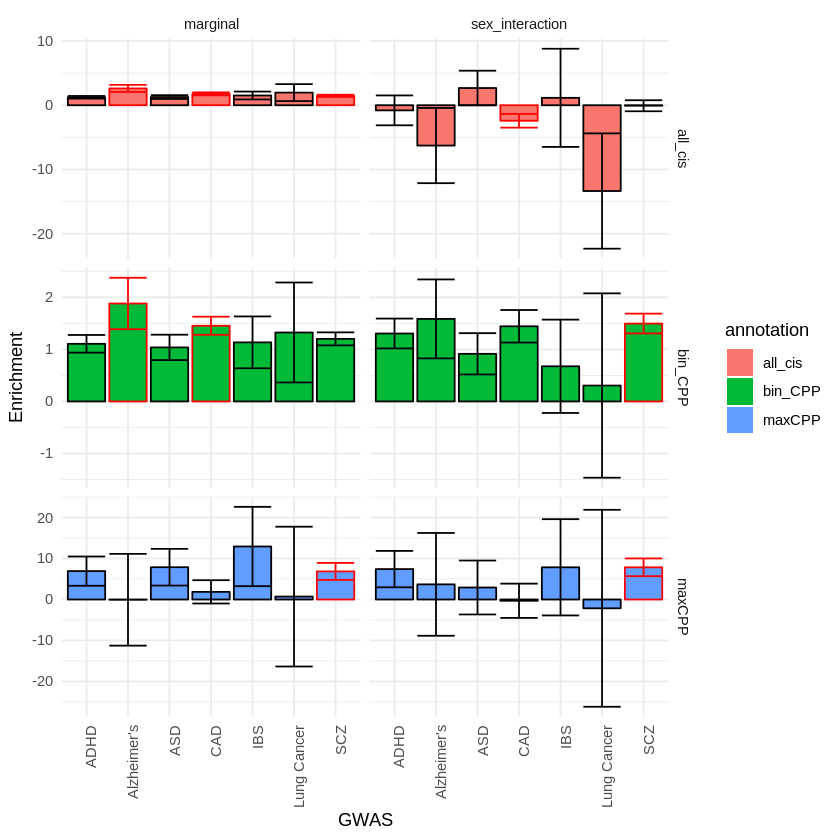

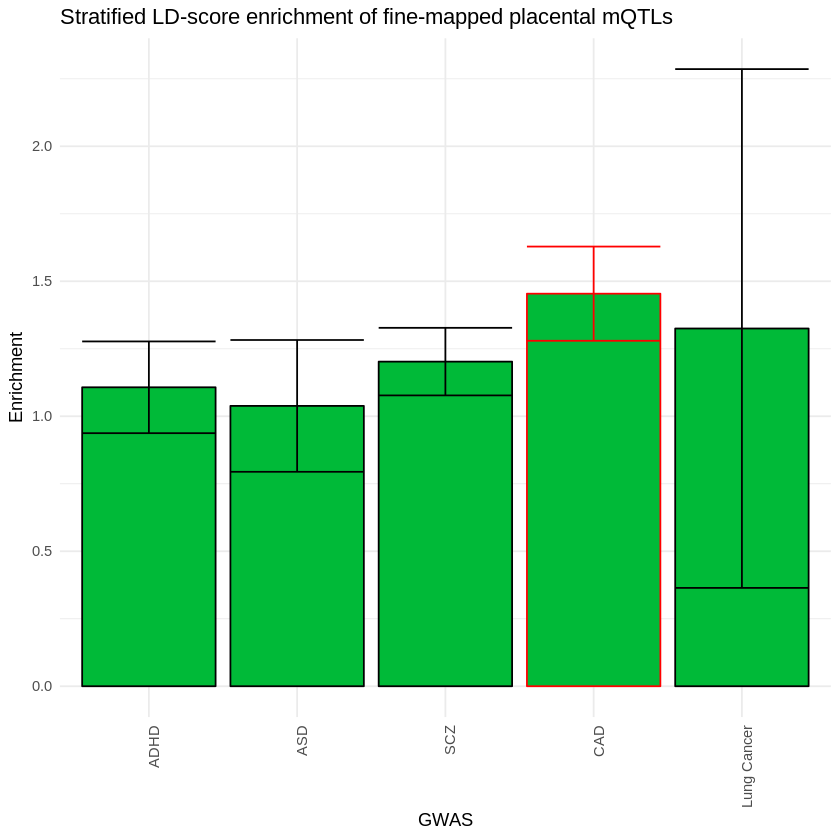

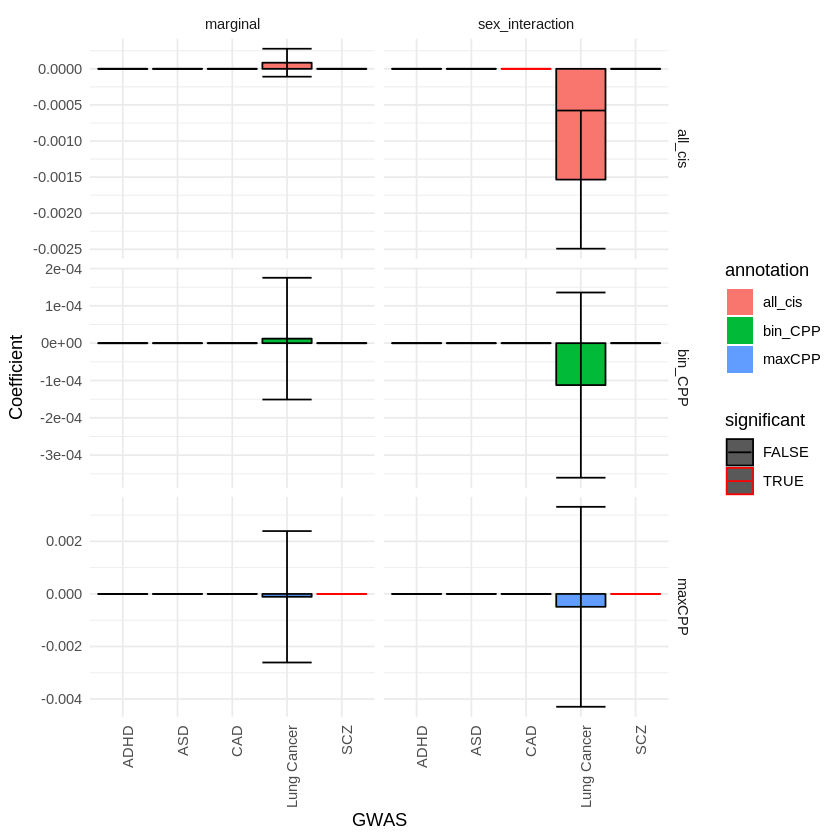

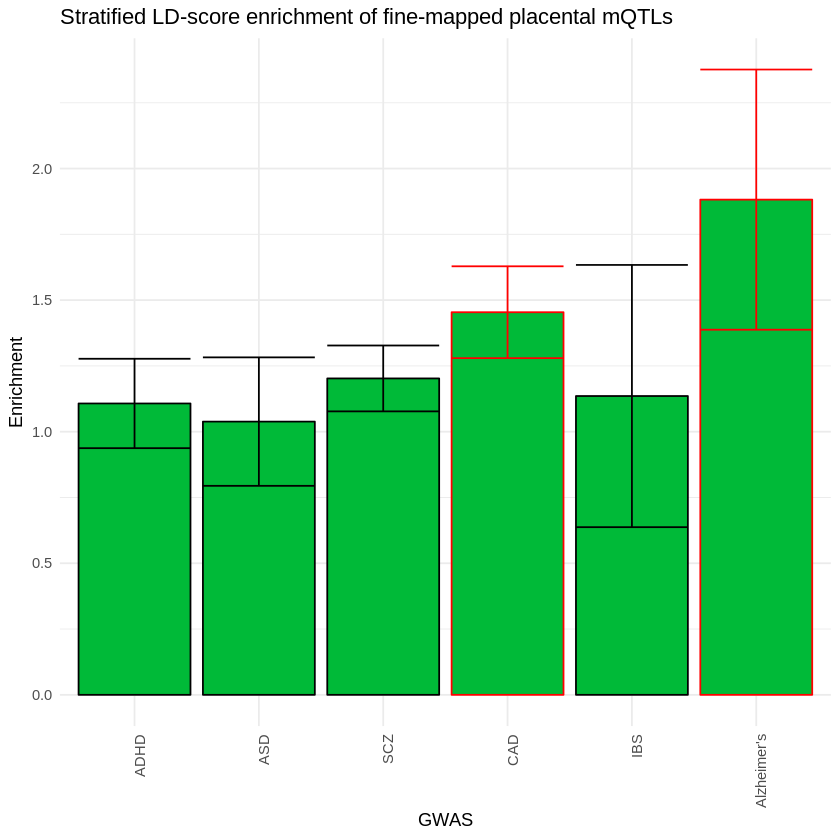

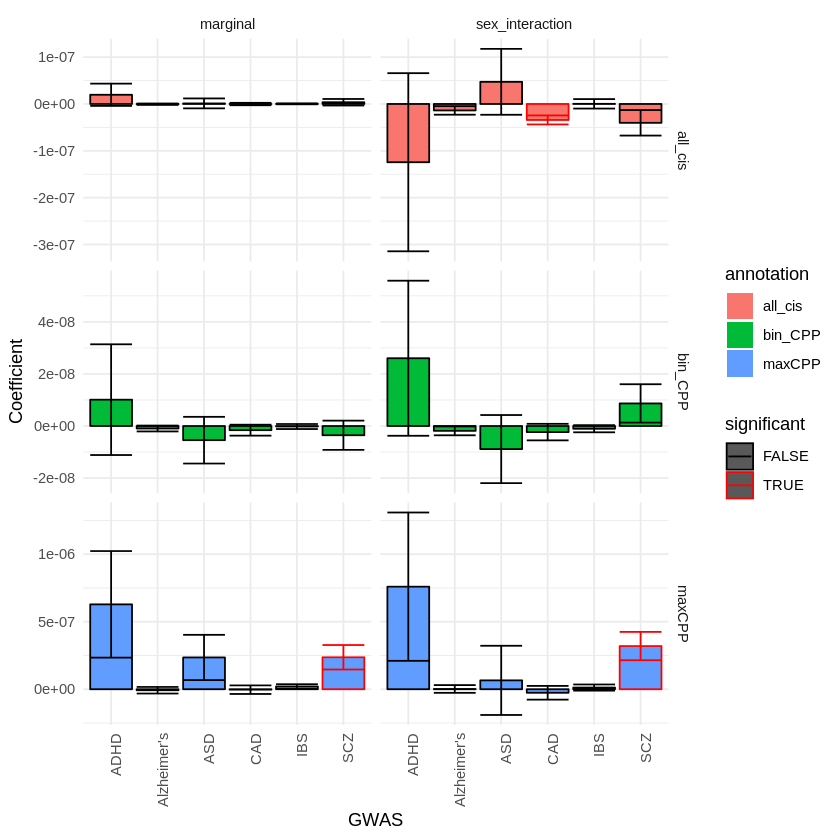

In [37]:
part_heritability_results <- lapply(
  dir(
    "/scratch/st-dennisjk-1/wcasazza/delahaye_QC/ldsc_results/",
    pattern = "[marginal|sex_interaction].*.results",
    full.names = TRUE
  ),
  function(f) {
    labels <- str_match(f, ".*/(marginal|sex_interaction)_(all_cis|bin_CPP|maxCPP)_(.*).results")[-c(1)]
    if (any(is.na(labels))) {
      return(data.table())
    } else {
      dt <- fread(f)[1, !"Category"]
      dt[, 
        `:=`(
          Coefficient_p=pnorm(abs(`Coefficient_z-score`),lower.tail=F)*2,
          mQTL_group = labels[1],
          annotation = labels[2],
          GWAS = labels[3])]
      return(dt)
    }
  }
)

part_heritability_df <- rbindlist(part_heritability_results)

# ggplot(part_heritability_df, aes(x=GWAS,y=Enrichment, fill=annotation,ymin=Enrichment-Enrichment_std_error,ymax=Enrichment+Enrichment_std_error)) + geom_bar(stat='identity',position="dodge") +geom_errorbar(position="dodge") + facet_grid(annotation~mQTL_group,scales = 'free_y') + theme_minimal() +theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1))
GWAS_key <- c(
    "AD_jansen_2019"="Alzheimer's",
    "adhd_jul2017"="ADHD",
    "CAD_META"="CAD",
    "IBS_Bonfiglio"="IBS",
    "iPSYCH-PGC_ASD_Nov2017"="ASD",
    "pancancer_2020_lung"="Lung Cancer",
    "rall_SCZ"="SCZ",
    "ukbb_preeclampsia_both_sexes"="PE Both Sexes",
    "ukbb_preeclampsia_female" = "PE Females only"

)
ggplot(
        part_heritability_df %>%
        filter(!grepl("preeclampsia",GWAS)) %>%
        mutate(significant=Enrichment_p < 0.05, GWAS = recode(GWAS, !!!GWAS_key)),
        aes(
            x=GWAS,
            y=Enrichment,
            fill=annotation,
            color=significant,
            ymin=Enrichment-Enrichment_std_error,
            ymax=Enrichment+Enrichment_std_error)
    ) + 
    geom_bar(stat='identity',position="dodge") +
    geom_errorbar(position="dodge") +
    facet_grid(annotation~mQTL_group,scales = 'free_y') +
    theme_minimal() +
    theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1)) +
    scale_color_manual(values=c("black","red"),guide='none')


subset_GWAS <- c("ADHD","ASD","SCZ","CAD", "Lung Cancer")
ggplot(
        part_heritability_df %>%
        filter(!grepl("preeclampsia",GWAS),annotation == "bin_CPP", mQTL_group == "marginal") %>%
        mutate(
            significant=Enrichment_p < 0.05,
            GWAS = recode(GWAS,!!!GWAS_key)
        ) %>% filter(GWAS %in% subset_GWAS ) %>% mutate(GWAS = factor(GWAS, levels= subset_GWAS)),
        aes(
            x=GWAS,
            y=Enrichment,
            fill=annotation,
            color=significant,
            ymin=Enrichment-Enrichment_std_error,
            ymax=Enrichment+Enrichment_std_error)
    ) + 
    geom_bar(stat='identity',position="dodge") +
    geom_errorbar(position="dodge") +
    theme_minimal() +
    theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1),legend.position = "") +
    scale_color_manual(values=c("black","red")) +
    scale_fill_manual(values="#00BA38")+
    ggtitle("Stratified LD-score enrichment of fine-mapped placental mQTLs")
ggplot(
        part_heritability_df %>%
            filter(!grepl("preeclampsia",GWAS))%>%
            mutate(significant = Coefficient_p < 0.05, GWAS = recode(GWAS,!!!GWAS_key)) %>% 
            filter(GWAS %in% subset_GWAS),
        aes(
            x=GWAS,
            y=Coefficient,
            fill=annotation,
            ymin=Coefficient-Coefficient_std_error,
            ymax=Coefficient+Coefficient_std_error,
            color=significant
        )
    ) + 
    geom_bar(stat='identity',position="dodge") +
    geom_errorbar(position="dodge") + 
    facet_grid(annotation~mQTL_group,scales = 'free_y') + 
    theme_minimal() +
    theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1)) +
    scale_color_manual(values=c("black","red"))


subset_GWAS <- c("ADHD","ASD","SCZ","CAD", "IBS", "Alzheimer's")
ggplot(
        part_heritability_df %>%
        filter(!grepl("preeclampsia",GWAS),annotation == "bin_CPP", mQTL_group == "marginal") %>%
        mutate(
            significant=Enrichment_p < 0.05,
            GWAS = recode(GWAS,!!!GWAS_key)
        ) %>% filter(GWAS %in% subset_GWAS ) %>% mutate(GWAS = factor(GWAS, levels= subset_GWAS)),
        aes(
            x=GWAS,
            y=Enrichment,
            fill=annotation,
            color=significant,
            ymin=Enrichment-Enrichment_std_error,
            ymax=Enrichment+Enrichment_std_error)
    ) + 
    geom_bar(stat='identity',position="dodge") +
    geom_errorbar(position="dodge") +
    theme_minimal() +
    theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1),legend.position = "") +
    scale_color_manual(values=c("black","red")) +
    scale_fill_manual(values="#00BA38")+
    ggtitle("Stratified LD-score enrichment of fine-mapped placental mQTLs")
ggplot(
        part_heritability_df %>%
            filter(!grepl("preeclampsia",GWAS))%>%
            mutate(significant = Coefficient_p < 0.05, GWAS = recode(GWAS,!!!GWAS_key)) %>% 
            filter(GWAS %in% subset_GWAS),
        aes(
            x=GWAS,
            y=Coefficient,
            fill=annotation,
            ymin=Coefficient-Coefficient_std_error,
            ymax=Coefficient+Coefficient_std_error,
            color=significant
        )
    ) + 
    geom_bar(stat='identity',position="dodge") +
    geom_errorbar(position="dodge") + 
    facet_grid(annotation~mQTL_group,scales = 'free_y') + 
    theme_minimal() +
    theme(axis.text.x=element_text(angle = 90,hjust=1,vjust=1)) +
    scale_color_manual(values=c("black","red"))


In [ ]:
part_heritability_df <- rbindlist(part_heritability_results)
ggplot(part_heritability_df %>% filter(mQTL_group=="marginal",!grepl("preeclampsia",GWAS),annotation=="all_cis") %>%mutate(significantly_enriched = Enrichment_p < 0.05), aes(x= GWAS, y= Prop._h2,ymin=Prop._h2-Prop._h2_std_error,ymax=Prop._h2+Prop._h2_std_error, fill = significantly_enriched)) + geom_bar(stat="identity") + geom_errorbar() +theme_minimal() + theme(axis.text.x = element_text(angle=90,hjust=1,vjust=1)) + ggtitle("Estimated heritabilityof Placental mQTLs")

ggplot(part_heritability_df %>% filter(mQTL_group=="marginal",!grepl("preeclampsia",GWAS),annotation=="all_cis") %>%mutate(significantly_enriched = Enrichment_p < 0.05), aes(x= GWAS, y= Enrichment,ymin=Enrichment-Enrichment_std_error,ymax=Enrichment+Enrichment_std_error, fill = significantly_enriched)) + geom_bar(stat="identity") + geom_errorbar() +theme_minimal() + theme(axis.text.x = element_text(angle=90,hjust=1,vjust=1)) + ggtitle("Enrichment of Placental mQTLs")

In [7]:
print(paste0(unique(part_heritability_df$GWAS),collapse=","))

[1] "AD_jansen_2019,adhd_jul2017,CAD_META,IBS_Bonfiglio,iPSYCH-PGC_ASD_Nov2017,pancancer_2020_lung,rall_SCZ,ukbb_preeclampsia_both_sexes,ukbb_preeclampsia_female"


Things to try, coord blood mQTLs as a negative control? something weird with pre-eclampsa, high enrichment but high standard error
## COLOC analysis
Things to try:
- Analysis of colocalization with certain GWAS loci (can also do this with eCAVIAR but may be more convenient with COLOC).
- Annotation based on binary 0-1 with more standard model

In [ ]:
library(coloc)